# This is the final report

In [1]:
import numpy as np
import pandas as pd
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pandas as pd
import os

csv_path = os.path.join(os.getcwd(), 'code_gpus', 'twitter-elon-tesla-bert.csv')
df = pd.read_csv(csv_path)
print(df.columns)
selected_columns = df[['Cleaned_Tweets', 'sentiment_score_bert']]

Index(['User', 'Username', 'UTC Date', 'post', 'Binders', 'Permalink',
       'reposts', 'Likes count', 'Impressions', 'Quotes', 'Replies',
       'Bookmarks', 'post value', 'Cleaned_Tweets', 'sentiment_score_bert'],
      dtype='object')


In the folder *code_gpus*, you will find the code that I used to perform computations on a GPU NVIDIA GeForce RTX 3090.

My strategy has been the following. First of all I have done some features engineering, I have cleaned the data, and I computed the correlation matrix to see if there was some pattern between the columns.

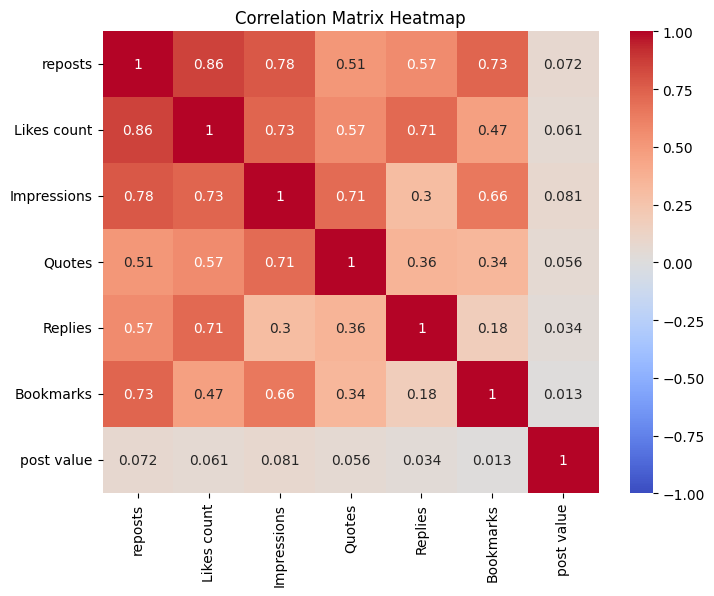

In [4]:
columns = ['reposts', 'Likes count', 'Impressions', 'Quotes', 'Replies',
       'Bookmarks', 'post value']
correlation_matrix = df[columns].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

Then, I computed the *sentiment_score_bert* using a pretrained model from *nlptown/bert-base-multilingual-uncased-sentiment*.

Using *TextBlob* instead, I visualized the plot of *'Subjectivity'* and *'Polarity'*:

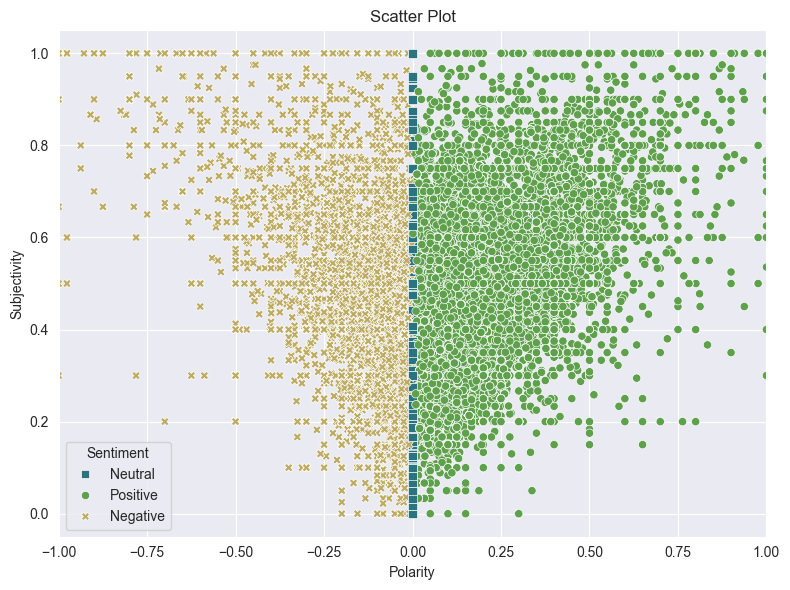

In [9]:
def getSubjectivity(twt):
  return TextBlob(twt).sentiment.subjectivity
df['Subjectivity'] = df['post'].apply(getSubjectivity)

def getPolarity(twt):
  return TextBlob(twt).sentiment.polarity
df['Polarity'] = df['post'].apply(getPolarity)

def getSentiment(value):
  if value < 0:
    return 'Negative'
  elif value > 0:
    return 'Positive'
  else:
    return 'Neutral'
  
df['Sentiment'] = df['Polarity'].apply(getSentiment)

sns.set_style('darkgrid')
plt.figure(figsize = (8,6))

markers = {'Positive':'o', 'Neutral':'s','Negative':'X'}

sns.scatterplot(data=df, x='Polarity', y='Subjectivity', hue = 'Sentiment', style = 'Sentiment', markers = markers, palette = 'gist_earth').set(xlim=(-1,1))
plt.title('Scatter Plot')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

plt.tight_layout()

## Extracting relevant information from sentiment_score_bert

In [10]:
df['UTC Date'] = pd.to_datetime(df['UTC Date'])

The following is a plot of the mean of *sentiment_score_bert* over each day.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


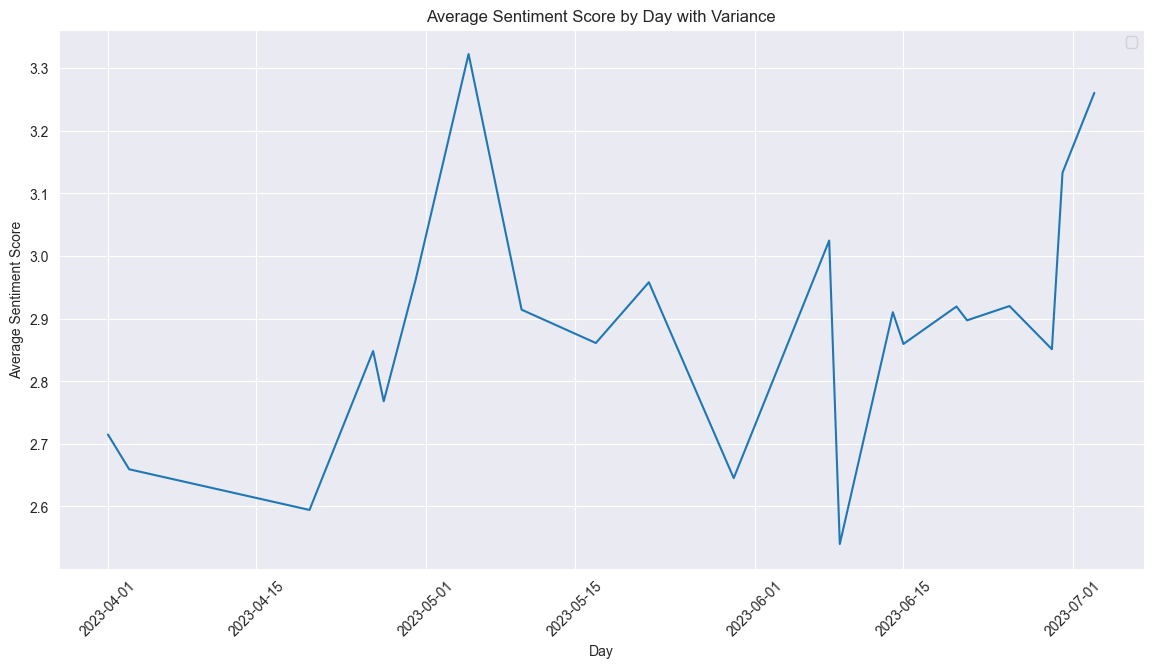

In [12]:
daily_sentiment_mean = df.groupby(df['UTC Date'].dt.date)['sentiment_score_bert'].mean().reset_index()
daily_sentiment_std = df.groupby(df['UTC Date'].dt.date)['sentiment_score_bert'].std().reset_index()
daily_sentiment_std.rename(columns={'sentiment_score_bert': 'sentiment_score_std'}, inplace=True)
daily_sentiment_mean.rename(columns={'sentiment_score_bert': 'sentiment_score_mean'}, inplace=True)

plt.figure(figsize=(14, 7))
sns.lineplot(data=daily_sentiment_mean, x='UTC Date', y='sentiment_score_mean')

dates = daily_sentiment_mean['UTC Date']
daily_means = daily_sentiment_mean['sentiment_score_mean']
daily_variance = daily_sentiment_std['sentiment_score_std']

plt.title('Average Sentiment Score by Day with Variance')
plt.xlabel('Day')
plt.ylabel('Average Sentiment Score')
plt.xticks(rotation=45)
plt.legend()
plt.show()

The follwing is a plot of the *standard_deviation* over each day:

<Axes: xlabel='UTC Date', ylabel='sentiment_score_std'>

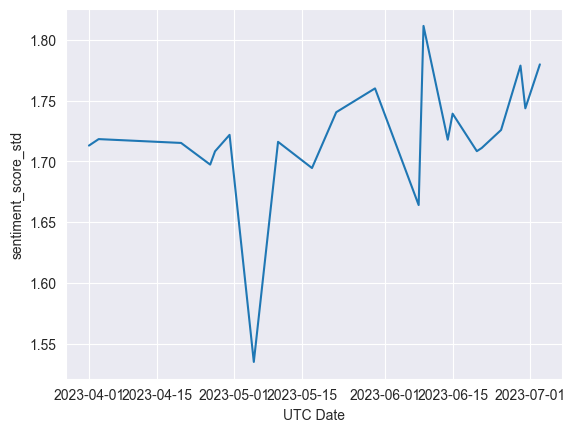

In [14]:
sns.lineplot(data=daily_sentiment_std, x='UTC Date', y='sentiment_score_std')

In [15]:
daily_sentiment = pd.merge(daily_sentiment_mean, daily_sentiment_std, on='UTC Date', suffixes=('_mean', '_std'))
min_std_value = daily_sentiment['sentiment_score_std'].min()
min_std_date = daily_sentiment[daily_sentiment['sentiment_score_std'] == min_std_value]['UTC Date'].iloc[0]
max_mean_value = daily_sentiment['sentiment_score_mean'].max()
max_mean_date = daily_sentiment[daily_sentiment['sentiment_score_mean'] == max_mean_value]['UTC Date'].iloc[0]

print(f"The minimum standard deviation is {min_std_value} on {min_std_date}")
print(f"The maximum mean is {max_mean_value} on {max_mean_date}")

The minimum standard deviation is 1.5348365486375268 on 2023-05-05
The maximum mean is 3.322420634920635 on 2023-05-05


In the previous piece of code, I realized that the maximum value for the mean and the minimum value for the standard_deviation happen in the same day.

Therefore, let us look at which is the post with the highest number on that day to understand what is going on.

In [16]:
max_impressions = df[df['UTC Date'].dt.date==min_std_date]['Impressions'].max()
post_max_impressions = df[df['Impressions']==max_impressions]['post'].iloc[0]

print(f"The post with the highest number of impressions on {min_std_date} is: ")
print(post_max_impressions)

The post with the highest number of impressions on 2023-05-05 is: 
In 1 week, 1M people have signed up for @OpenAI's new chatbot, ChatGPT to experience what is being offered by the Elon Musk and Sam Altman founded company. 

Todd Price interviewed the ChatGPT bot about its plans for monetisation &amp; choice of blockchain:


Therefore, our conclusion is that on that day, there was a general positive trend accompanied by strong consensus, as indicated by the low standard deviation. Notably, we have also observed that, on that same day, just one week after its release, one million people had already signed up for OpenAI's new chatbot.